In [1]:
# Add the project root and src directory to Python path
import sys, pathlib
repo_root = pathlib.Path.cwd()
while not (repo_root / 'setup.py').exists() and repo_root != repo_root.parent:
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / 'src'))


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import pyepo
from sklearn.model_selection import train_test_split
from src.models.LinearRegression import LinearRegression

from src.solvers.spnia_asym import AsymmetricSPNI
from src.models.ShortestPathGrb import shortestPathGrb
from src.models.ShortestPathGrid import ShortestPathGrid
from src.solvers.BendersDecomposition import BendersDecomposition
from data.DataGenerator import DataGenerator
from models.trainer import Trainer

In [3]:
# Define hyperparameters
c_min: float = 1.0
c_max: float = 10.0
d_min: float = 1.0
d_max: float = 10.0
Q = 0.6
B = 5
network = (6, 8)
random_seed = 31

# ML hyperparameters
num_features = 5
num_data_samples = 100
test_size = 0.2
data_loader_batch_size = 32
epochs = 5

# Set the random seed for reproducibility
np.random.seed(random_seed)

In [4]:
# Define a graph with appropriate dimensions and an opt_model 
# for solving the shortest path problem on the graph
graph = ShortestPathGrid(network[0], network[1])
opt_model = shortestPathGrb(graph)

Restricted license - for non-production use only - expires 2026-11-23


In [5]:
# # Generate artificial data samples
# data_gen = DataGenerator(
#     num_costs=graph.num_cost,
#     num_features=num_features,
#     cost_feature_map="PolynomialKernel",
#     c_range=(c_min, c_max),
#     epsilon_bar=0.05
# )
# costs, features = data_gen.generate_data(num_samples=num_data_samples)

features, costs = pyepo.data.shortestpath.genData(
    1000, 
    num_features, 
    (graph.m, graph.n), 
    deg=3, 
    noise_width=0.05, 
    seed=31
)

# Split the data into training and testing sets
X_train, X_test, c_train, c_test = train_test_split(features, costs, test_size=test_size, random_state=random_seed)


## Predict-then-Optimize

In [6]:
# 1) Define your network dimensions
input_size  =  num_features   # e.g. number of features in your cost‐vector
hidden_size =  64   # number of neurons in the hidden layer
output_size =  graph.num_cost   # e.g. # of target outputs, or number of classes

# 2) Build the model with nn.Sequential
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),  # first affine layer
    nn.ReLU(),                           # non‐linearity
    nn.Linear(hidden_size, output_size)  # second affine layer
)

# 3) Define deviece and move the model to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4) Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5) Create DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(c_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=data_loader_batch_size, shuffle=True)

In [7]:
# 6) Training loop
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(x_batch)
        loss   = criterion(y_pred, y_batch)

        # Backprop + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.3292
Epoch 2, Loss: 0.1779
Epoch 3, Loss: 0.0996
Epoch 4, Loss: 0.0505
Epoch 5, Loss: 0.0410


## Smart Predict-then-Optimize with OptNet

In [8]:
# Create data loaders for training and testing
train_dataset = pyepo.data.dataset.optDataset(opt_model, X_train, c_train)
test_dataset = pyepo.data.dataset.optDataset(opt_model, X_test, c_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=data_loader_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=data_loader_batch_size, shuffle=False)

Optimizing for optDataset...


  0% 0/800 [00:00<?, ?it/s]

  8% 63/800 [00:00<00:01, 623.63it/s]

 16% 127/800 [00:00<00:01, 628.48it/s]

 24% 190/800 [00:00<00:00, 619.06it/s]

 32% 255/800 [00:00<00:00, 628.97it/s]

 40% 319/800 [00:00<00:00, 629.24it/s]

 48% 385/800 [00:00<00:00, 638.89it/s]

 56% 452/800 [00:00<00:00, 646.69it/s]

 65% 519/800 [00:00<00:00, 651.52it/s]

 73% 587/800 [00:00<00:00, 659.73it/s]

 82% 653/800 [00:01<00:00, 656.55it/s]

 90% 719/800 [00:01<00:00, 653.90it/s]

 98% 785/800 [00:01<00:00, 648.73it/s]

100% 800/800 [00:01<00:00, 643.69it/s]

Optimizing for optDataset...


  0% 0/200 [00:00<?, ?it/s]

 35% 70/200 [00:00<00:00, 698.51it/s]

 70% 140/200 [00:00<00:00, 679.26it/s]

100% 200/200 [00:00<00:00, 682.86it/s]

In [9]:
# Instantiate linear regression model
# model = LinearRegression(num_feat=num_features, num_edges=graph.num_cost)
import torch
import torch.nn as nn

# 1) Define your network dimensions
input_size  =  num_features   # e.g. number of features in your cost‐vector
hidden_size =  64   # number of neurons in the hidden layer
output_size =  graph.num_cost   # e.g. # of target outputs, or number of classes

# 2) Build the model with nn.Sequential
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),  # first affine layer
    nn.ReLU(),                           # non‐linearity
    nn.Linear(hidden_size, output_size)  # second affine layer
)

# Init SPO+ loss
spop = pyepo.func.SPOPlus(opt_model, processes=1)

# Init optimizer
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=.1)

Num of cores: 1


In [10]:
# Create a trainer instance and train the model using SPO+
trainer = Trainer(pred_model=model,
                  opt_model=opt_model,
                  optimizer=optimizer,
                  loss_fn=spop
                )

train_loss_log, train_regret_log, test_loss_log, test_regret_log = trainer.fit(train_loader, test_loader, epochs=epochs)

Epoch 00 | Train Loss: 3.9955 | Train Regret: 0.0302 | Test Loss: 2.2668 | Test Regret: 0.0349


Epoch 01 | Train Loss: 2.4094 | Train Regret: 0.0309 | Test Loss: 2.7844 | Test Regret: 0.0355


Epoch 02 | Train Loss: 2.0690 | Train Regret: 0.0310 | Test Loss: 2.4882 | Test Regret: 0.0382


Epoch 03 | Train Loss: 2.1308 | Train Regret: 0.0333 | Test Loss: 1.8917 | Test Regret: 0.0327


Epoch 04 | Train Loss: 2.0197 | Train Regret: 0.0243 | Test Loss: 2.0821 | Test Regret: 0.0320


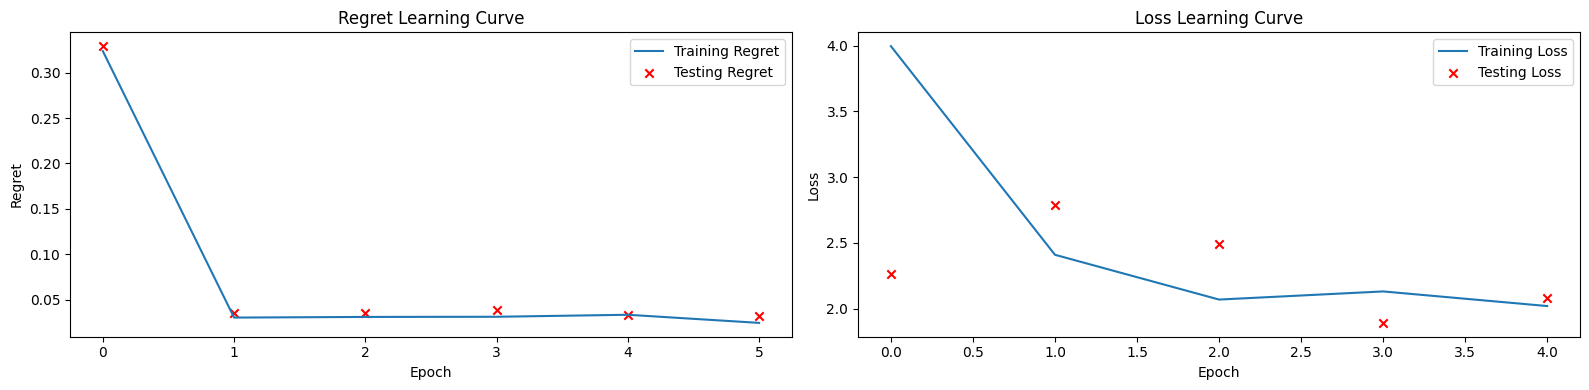

Final regret on test set: 0.032000573746852015
Predicted shortest path objective: -7.376911140978336
Predicted path vector: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [11]:
# Plot training loss and regret similar to Trainer.vis_learning_curve
def plot_learning_curve(train_loss_log, train_regret_log, test_loss_log=None, test_regret_log=None, n_epochs=trainer.n_epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    ax1.plot(train_regret_log, label='Training Regret')
    if test_regret_log is not None:
        ax1.scatter(np.arange(len(test_regret_log))*n_epochs, test_regret_log, marker='x', color='red', label='Testing Regret')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Regret')
    ax1.set_title('Regret Learning Curve')
    ax1.legend()

    ax2.plot(train_loss_log, label='Training Loss')
    if test_loss_log is not None:
        ax2.scatter(np.arange(len(test_loss_log))*n_epochs, test_loss_log, marker='x', color='red', label='Testing Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss Learning Curve')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curve(train_loss_log, train_regret_log, test_loss_log, test_regret_log)

print('Final regret on test set:', test_regret_log[-1])

# Use the trained model with the optimization layer to compute a shortest path for one test sample
sample_feat = torch.tensor(X_test[0], dtype=torch.float32).to(device)
with torch.no_grad():
    pred_cost = model(sample_feat).cpu().numpy()
opt_model.setObj(pred_cost)
pred_path, pred_obj = opt_model.solve()
print('Predicted shortest path objective:', pred_obj)
print('Predicted path vector:', pred_path)
